In [3]:
pip install scikit-image

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-1.8/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import cv2
import pandas as pd
import math
from sklearn.preprocessing import LabelEncoder
from skimage import feature as skif
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [5]:
def loadDataProcessing(file):
    with open(file) as f:
        s = f.read().splitlines()  # 读取逐行数据放入list列表中
    allMessage = []
    for i in range(len(s)):
        # print(s[9])#打印第九行
        temp = s[i]
        temp = temp.split(' ')  # 按空格划分字符串为list列表
        while '' in temp:  # 删除list中的空元素
            temp.remove('')
        # print(temp)

        # 对单行进行赋值处理
        if len(temp) > 10:
            id = temp[0]
            sex = temp[2][:-1]
            age = temp[4][:-1]
            race = temp[6][:-1]
            face = temp[8][:-1]
            prop = temp[10:]
            prop[0] = prop[0][2:]

            prop.pop(-1)
            # 判断prop是否为空，并且根据prop特征的个数来用空格进行拼接
            if len(prop) != 0:
                str = ''
                for i in range(len(prop) - 1):
                    str = str + prop[i] + ' '
                str = str + prop[len(prop) - 1]
                prop = str
            else:
                prop = 'NaN'

            # print(prop)
            temp = [id, sex, age, race, face, prop]
            allMessage.append(temp)
        # print(temp)
        else:
            pass
    return allMessage

In [6]:
def roadLabels(path):
    # 将字符串标签“male”，“female”处理为1，0
    if (type(path).__name__ == 'list'):  # 用于处理列表数据
        labels = []
        for i in range(len(y)):
            labels.append(y[i][1])
    else:  # 用于处理csv文件
        df = pd.read_csv(path)
        labels = df.iloc[:, 1].values.tolist()

    # 给标签编码
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    # print(labels)
    return labels

def roadData(path):
    # 读取文件夹下的文件，返回一个list列表
    path = path  # 文件夹目录
    files = os.listdir(path)  # 得到文件夹下的所有文件名称
    # f = open(path+"/"+files[0],'rb')
    # s=np.fromfile(f,dtype=np.ubyte)
    # s=np.int_(s)
    # flag=0
    s = []
    for file in files:  # 遍历文件夹
        with open(path + '/' + file, 'rb') as f:
            x = np.fromfile(f, dtype=np.uint8)

            if len(x) == 128 * 128:
                x = x.reshape(128, 128)

            s.append(x)

    return s

In [7]:
def get_lbp_data(img, lbp_radius, lbp_point):

    lbpImg = img.copy()
    # 使用LBP方法提取图像的纹理特征.
    lbp = skif.local_binary_pattern(lbpImg, lbp_point, lbp_radius, 'default')

    return lbp


def get_pixel_else_0(l, idx, idy):
    if idx < int(len(l)) - 1 and idy < len(l[0]):
        return l[idx, idy]
    else:
        return 0


def bilinearInterpolation(x, y, img):
    x1, y1 = int(x), int(y)
    x2, y2 = math.ceil(x), math.ceil(y)

    r1 = (x2 - x) / (x2 - x1) * get_pixel_else_0(img, x1, y1) + (x - x1) / (x2 - x1) * get_pixel_else_0(img, x2, y1)
    r2 = (x2 - x) / (x2 - x1) * get_pixel_else_0(img, x1, y2) + (x - x1) / (x2 - x1) * get_pixel_else_0(img, x2, y2)

    return (y2 - y) / (y2 - y1) * r1 + (y - y1) / (y2 - y1) * r2


def thresholded(center, pixels):
    out = []
    if len(pixels) > 0:
        out = np.where((pixels - center) >= 0, 1, 0)
    return out

In [8]:
def getNeighboringPixelsPaperVersion(img, R, P, x, y):
    pixels = []

    indexes = np.array(list(range(0, P)), dtype=np.float64)
    dy = -R * np.sin(2 * np.pi * indexes / P)
    dx = R * np.cos(2 * np.pi * indexes / P)

    dy = np.where(abs(dy) < 5.0e-10, 0, dy)
    dx = np.where(abs(dx) < 5.0e-10, 0, dx)

    for point in range(0, P):
        r = y + dy[point]
        c = x + dx[point]

        fr = math.floor(r)
        fc = math.floor(c)

        cr = math.ceil(r)
        cc = math.ceil(c)

        rr = np.round(r)
        rc = np.round(c)

        if abs(c - rc) < 10e-7 and abs(r - rr) < 10e-7:
            pixels.append(get_pixel_else_0(img, int(r), int(c)))
        else:
            tr = r - fr
            tc = c - fc

            w1 = (1 - tc) * (1 - tr)
            w2 = tc * (1 - tr)
            w3 = (1 - tc) * tr
            w4 = tc * tr

            value = w1 * get_pixel_else_0(img, fr, fc) + w2 * get_pixel_else_0(img, fr, cc) + \
                    w3 * get_pixel_else_0(img, cr, fc) + w4 * get_pixel_else_0(img, cr, cc)

            pixels.append(value)

    return pixels

In [9]:
def getNeighboringPixels(img, R, P, x, y):
    pixels = []

    indexes = np.array(list(range(0, P)), dtype=np.float64)
    dy = -R * np.sin(2 * np.pi * indexes / P)
    dx = R * np.cos(2 * np.pi * indexes / P)

    dy = np.where(abs(dy) < 5.0e-10, 0, dy)
    dx = np.where(abs(dx) < 5.0e-10, 0, dx)

    for point in range(0, P):
        c = x + dx[point]
        r = y + dy[point]

        if r < 0 or c < 0:
            pixels.append(0)
            continue
        if int(r) == r:
            if int(c) != c:
                c1 = int(c)
                c2 = math.ceil(c)
                w1 = (c2 - c) / (c2 - c1)
                w2 = (c - c1) / (c2 - c1)

                pixels.append(int((w1 * get_pixel_else_0(img, int(r), int(c)) + \
                                   w2 * get_pixel_else_0(img, int(r), math.ceil(c))) / (w1 + w2)))
            else:
                pixels.append(get_pixel_else_0(img, int(r), int(c)))
        elif int(c) == c:
            r1 = int(r)
            r2 = math.ceil(r)
            w1 = (r2 - r) / (r2 - r1)
            w2 = (r - r1) / (r2 - r1)
            pixels.append((w1 * get_pixel_else_0(img, int(r), int(c)) + \
                           w2 * get_pixel_else_0(img, math.ceil(r), int(c))) / (w1 + w2))
        else:
            pixels.append(bilinearInterpolation(r, c, img))

    return pixels

In [10]:
def genMappingTable(P):
    mapTable = np.zeros(2 ** P)
    numElms = P + 2
    for i in range(0, 2 ** P):
        msb = 128 & i
        lsb = 1 & i
        count = format(i, '#010b').count('01') + format(i, '#010b').count('10') + ((msb >> (P - 1)) ^ lsb)

        if count <= 2:
            mapTable[i] = bin(i).count('1')
        else:
            mapTable[i] = P + 1

    return mapTable


def LBP(img, R, P):
    lbpImg = img.copy()

    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            center = img[x, y]
            pixels = getNeighboringPixels(img, R, P, x, y)
            values = thresholded(center, pixels)

            res = 0
            for a in range(0, len(values)):
                res += values[a] * (2 ** a)
            lbpImg.itemset((x, y), res)

    return lbpImg


def ULBP(img, R, P):
    uLbpImg = img.copy()
    p = np.array(list(range(1, P)))

    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            center = img[x, y]
            pixels = getNeighboringPixels(img, R, P, x, y)
            values = np.array(thresholded(center, pixels))
            res = abs(values[P - 1] - values[0])
            res += np.sum(abs(values[p] - values[p - 1]))
            uLbpImg.itemset((x, y), res)

    return uLbpImg


def LBPriu2(img, R, P):
    uLbpImg = ULBP(img, R, P)

    lbpRiu2Img = img.copy()

    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            if uLbpImg[x, y] <= 2:
                center = img[x, y]
                pixels = getNeighboringPixels(img, R, P, x, y)
                values = np.array(thresholded(center, pixels))
                lbpRiu2Img.itemset((x, y), np.sum(values))
            else:
                lbpRiu2Img.itemset((x, y), P + 1)
    return lbpRiu2Img


def calcCLBPMThreshold(img, P, R):
    threshold = 0
    total = 0

    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            center = img[x, y]
            pixels = getNeighboringPixels(img, R, P, x, y)
            sp, mp = LDSMT(center, pixels)
            total += np.mean(mp)

    return total / (len(img) * len(img[0]))


def calcLocalDifferences(img, P, R):
    ld = np.zeros((img.shape[0], img.shape[1], P), dtype=np.float64)

    for y in range(0, len(img)):
        for x in range(0, len(img[0])):
            center = img[y, x]
            # pixels = getNeighboringPixels(img,R,P,x,y)
            pixels = getNeighboringPixelsPaperVersion(img, R, P, x, y)
            ld[y, x, 0:P] = pixels - center

    return ld

In [11]:
def calcTransitions(pattern, P):
    u_value = np.absolute(pattern[:, :, P - 1] - pattern[:, :, 0])
    u_value += np.sum(np.absolute(pattern[:, :, 1:P] - pattern[:, :, 0:P - 1]), 2)
    return u_value


def LDSMT(ld):
    sp = np.where(ld >= 0, 1, -1)
    mp = np.absolute(ld)
    return sp, mp


def CLBP_S(sp, P):
    sp = np.where(sp >= 0, 1, 0)
    pp2 = 2 ** (np.array(list(range(0, P))))
    return np.dot(sp, pp2)


def CLBP_M(mp, P):
    c = np.mean(mp)
    tp = np.where(mp >= c, 1, 0)
    pp2 = (np.array(list(range(0, P))))
    return np.dot(tp, pp2)


def CLBP_C(im):
    c = np.mean(im)
    return np.where(im >= c, 1, 0)


def CLBP_S_riu2(sp, P):
    sp = np.where(sp >= 0, 1, 0)
    pp2 = 2 ** (np.array(list(range(0, P))))
    indexes = np.dot(sp, pp2)
    return indexes


def CLBP_M_riu2(mp, P):
    c = np.mean(mp)
    tp = np.where(mp >= c, 1, 0)
    pp2 = 2 ** (np.array(list(range(0, P))))
    indexes = np.dot(tp, pp2)
    return indexes

In [12]:
def brint_s(srcimg, radius, neighbours):

    src = srcimg
    n_images = srcimg.shape[0]
    hist = np.zeros((n_images, 256))
    q = int(neighbours / 8)
    neighbourhoodCoords = getNeighbourhoodCoordinates(radius, neighbours)

    height = src.shape[0] - 2 * radius  # rows
    width = src.shape[1] - 2 * radius  # cols
    # print(height, width)

    dst = np.zeros((height, width), dtype=np.uint8)
    # dst = src.resize(height,width)
    # cv2.imshow("1",dst)
    # cv2.waitKey(0)
    # print(radius,height+radius,width+radius)
    # for i in np.arange(n_images):
    for y in range(radius, height + radius):
        for x in range(radius, width + radius):
            # 获得邻域
            neighbourhood = src[int(x - radius):int(x + radius + 1), int(y - radius):int(y + radius + 1)]
            # print(neighbourhood)
            nData = neighbourhood.data
            # 邻域像素值
            neighbourVector = np.zeros(neighbours, dtype=float)

            for p in range(0, neighbours):
                xy = neighbourhoodCoords[p]

                p1 = neighbourhood[int(xy[1]), int(xy[0])]
                p2 = neighbourhood[int(xy[1]), int(xy[2])]
                p3 = neighbourhood[int(xy[3]), int(xy[0])]
                p4 = neighbourhood[int(xy[3]), int(xy[2])]
                neighbourVector[p] = xy[4] * p1 + xy[5] * p2 + xy[6] * p3 + xy[7] * p4

            bnt_s = 0
            for i in range(0, 8):
                m = 0
                for k in range(0, q):
                    m += neighbourVector[q * i + k]
                m /= q
                if m - nData[radius, radius] >= 0:
                    s = 1
                else:
                    s = 0
                bnt_s += s * (2 ** i)

            dst[y - radius, x - radius] = float(minROR(bnt_s, q))

    tmp1 = np.zeros((height, width), dtype=np.uint8)
    cv2.transpose(dst, tmp1)

    return tmp1


def getNeighbourhoodCoordinates(radius, neighbours):
    neighbourhoodCoords = np.zeros((neighbours, 8), dtype=float)
    for i in range(0, neighbours):
        # neighbourhoodCoord = np.zeros(8,dtype=float)
        x = float(radius * math.cos(i * 2 * math.pi / neighbours) + radius)
        y = float(radius * math.sin(i * 2 * math.pi / neighbours + radius))

        neighbourhoodCoords[i, 0] = math.floor(x)
        neighbourhoodCoords[i, 1] = math.floor(y)
        neighbourhoodCoords[i, 2] = math.ceil(x)
        neighbourhoodCoords[i, 3] = math.ceil(y)

        tx = float(x - math.floor(x))
        ty = float(y - math.floor(y))

        neighbourhoodCoords[i, 4] = (1 - tx) * (1 - ty)
        neighbourhoodCoords[i, 5] = tx * (1 - ty)
        neighbourhoodCoords[i, 6] = (1 - tx) * ty
        neighbourhoodCoords[i, 7] = tx * ty

    return neighbourhoodCoords


def minROR(x, numShifts):
    m = x
    for i in range(1, numShifts):
        m = min(m, (x >> i) | (x << (8 - i)))

    return m

extracting feature with CLBP...


100%|██████████| 3991/3991 [3:17:24<00:00,  2.97s/it]  


extraction completed !
[0.64164956 0.18764415]
CLBP_M:
混淆矩阵：
[[ 83 250]
 [ 26 440]]
准确率： 0.6545682102628285
精确率： 0.6376811594202898
查全率： 0.944206008583691
F1值： 0.7612456747404843
AUC值： 0.6627614739202723


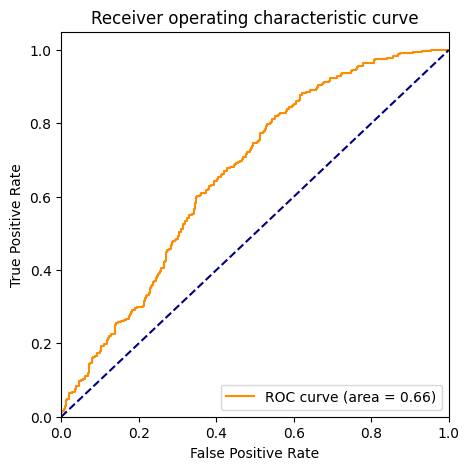

[0.7899559  0.08801841]
CLBP_S:
混淆矩阵：
[[ 35 298]
 [  9 457]]
准确率： 0.6157697121401752
精确率： 0.6052980132450331
查全率： 0.98068669527897
F1值： 0.7485667485667487
AUC值： 0.652212298135045


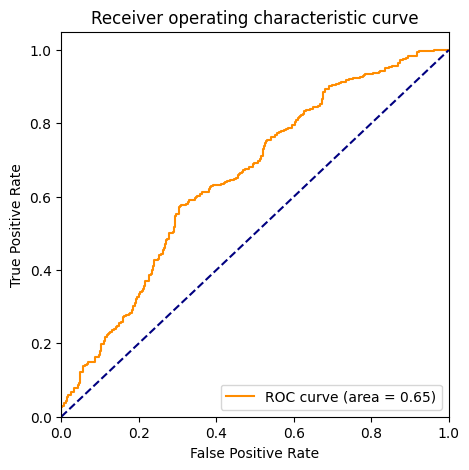

[0.55250203 0.15090799]
CLBP_M/C:
混淆矩阵：
[[ 84 249]
 [ 37 429]]
准确率： 0.6420525657071339
精确率： 0.6327433628318584
查全率： 0.9206008583690987
F1值： 0.7499999999999999
AUC值： 0.6400262923868074


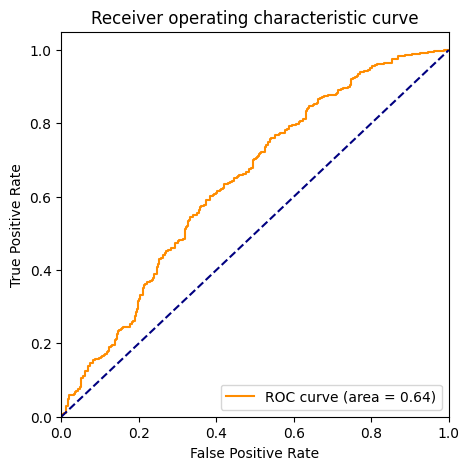

[0.61896157 0.10383947]
CLBP_S_M/C:
混淆矩阵：
[[ 42 291]
 [ 20 446]]
准确率： 0.6107634543178974
精确率： 0.6051560379918589
查全率： 0.9570815450643777
F1值： 0.741479634247714
AUC值： 0.6245021845880215


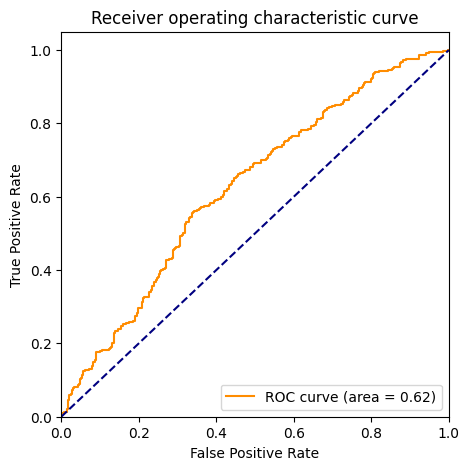

[0.47953351 0.13554761]
CLBP_S/M:
混淆矩阵：
[[ 79 254]
 [ 16 450]]
准确率： 0.6620775969962454
精确率： 0.6392045454545454
查全率： 0.9656652360515021
F1值： 0.7692307692307693
AUC值： 0.6769967392284989


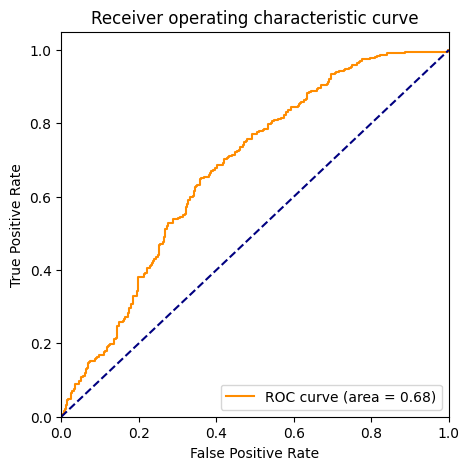

[0.40391452 0.07063322]
CLBP_S/M/C:
混淆矩阵：
[[ 87 246]
 [ 21 445]]
准确率： 0.6658322903629537
精确率： 0.6439942112879884
查全率： 0.9549356223175965
F1值： 0.7692307692307692
AUC值： 0.6884932142442872


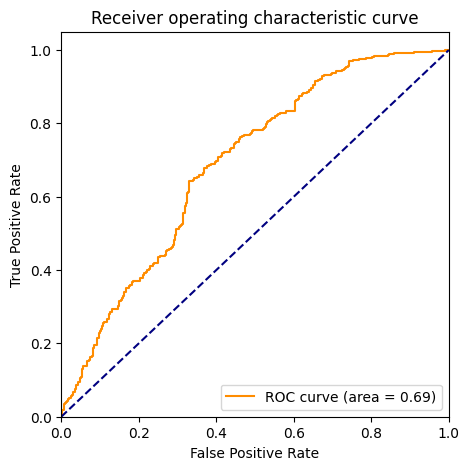

In [13]:
if __name__ == '__main__':
    # 原始数据处理——————————————————————————————————————————————————————————————------------------------------------------
    # 将性别与图片相匹配
    # x, y = match_PicGen("./rawdata", 'faceDR', 'faceDS')  # 读取文件夹下的文件

    x = roadData("./rawdata")  # 读取文件夹下的文件
    # 使用原始数据标签
    y1 = loadDataProcessing('faceDR')
    y2 = loadDataProcessing('faceDS')
    y = y1 + y2
    # 只留性别标签
    y = roadLabels(y)
    # 剔除超过128*128的数据和标签
    x.pop(1190)
    x.pop(1186)
    y = np.delete(y, 1190)
    y = np.delete(y, 1186)


    # gendata即为性别数据集，共3991列，每行第0位元素为性别标签，第1位是对应像素矩阵
    gendata = []
    for i in range(len(y)):
        for j in range(len(x)):
            if i == j:
                t = (y[i], x[j],)
                gendata.append(t)

    # 展示其中一张图片
    # cv2.imshow("orgin", gendata[37][1])
    # cv2.waitKey(0)

    # 其中一张图片特征对比
    img = gendata[3906][1]

    img = img / 255
    img = (img - np.mean(img)) / np.std(img) * 20 + 128

    radius = 1
    numPoints = 8

    # dp = calcLocalDifferences(img, numPoints, radius)
    # sp, mp = LDSMT(dp)

    mappingTable = genMappingTable(numPoints)


    # 特征提取(CLBP_S/M/C)————————————————————————————————————————————————————————————————————————————————————————————————
    g_feature_m = []
    g_feature_s = []
    g_feature_mc = []
    g_feature_s_mc = []
    g_feature_sm = []
    g_feature_smc = []
    g_lable = []

    print("extracting feature with CLBP...")
    for img in tqdm(gendata):
        # radius = 1
        # numPoints = 8
        #         bins_i=n + 2
        dp = calcLocalDifferences(img[1], numPoints, radius)
        sp, mp = LDSMT(dp)

        # CLBP_C
        clbp_c = CLBP_C(img[1])

        # CLBP_M
        clbp_m_riu2 = CLBP_M_riu2(mp, numPoints)
        mapped_clbp_m_riu2 = mappingTable[clbp_m_riu2]
        (hist_m, bins) = np.histogram(mapped_clbp_m_riu2, bins=numPoints + 2)

        # CLBP_S
        clbp_s_riu2 = CLBP_S_riu2(sp, numPoints)
        mapped_clbp_s_riu2 = mappingTable[clbp_s_riu2]
        (hist_s, bins) = np.histogram(mapped_clbp_s_riu2, bins=numPoints + 2)

        # CLBP_M/C
        hist_mc, xedges, yedges = np.histogram2d(mapped_clbp_m_riu2.flatten(), clbp_c.flatten(), bins=[numPoints + 2, 2])

        # CLBP_S_M/C
        hist_s_mc = np.concatenate((hist_s.flatten(), hist_mc.flatten()), axis=0)

        # CLBP_S/M
        hist_sm, xedges, yedges = np.histogram2d(mapped_clbp_s_riu2.flatten(), mapped_clbp_m_riu2.flatten(), bins=[numPoints + 2, numPoints + 2])

        # CLBP_S/M/C
        clbp_mc_sum = np.where(clbp_c > 0, clbp_m_riu2 + numPoints + 2, clbp_m_riu2)
        hist_smc, xedges, yedges = np.histogram2d(mapped_clbp_s_riu2.flatten(), clbp_mc_sum.flatten(), bins=[numPoints + 2, 2 * (numPoints + 2)])

        g_feature_m.append(hist_m)
        g_feature_s.append(hist_s)
        g_feature_mc.append(hist_mc)
        g_feature_s_mc.append(hist_s_mc)
        g_feature_sm.append(hist_sm)
        g_feature_smc.append(hist_smc)

        lable = img[0]
        g_lable.append(lable)
    print("extraction completed !")

    # SVM分类及性能评估————————————————————————————————————————————————————————————————————————————————————————————————————
    titles = ['CLBP_M:', 'CLBP_S:', 'CLBP_M/C:', 'CLBP_S_M/C:', 'CLBP_S/M:', 'CLBP_S/M/C:']
    Gfeatures = [g_feature_m, g_feature_s, g_feature_mc, g_feature_s_mc, g_feature_sm, g_feature_smc]
    # 划分训练集与测试集
    for i in range(len(Gfeatures)):

        # 降维:
        Gfea = np.array(Gfeatures[i])

        re_Gfeature = []
        for mat in Gfea:
            res = np.array(mat).reshape(-1)
            re_Gfeature.append(res)
        # print(re_Gfeature)
        re_Gfeature = np.array(re_Gfeature)
        # print('re_fea_shape:', re_Gfeature.shape)
        # print('re_Gfeature[0]:', re_Gfeature[0])

        # 标准化—————————————————————————————————
        scaler = MinMaxScaler()
        scaler.fit(re_Gfeature)
        re_Gfeature = scaler.transform(re_Gfeature)

        # PCA降维———————————————————————————————
        pca = decomposition.PCA(n_components=2)
        pca.fit(re_Gfeature)
        # 观察占比可以选择降多少维
        print(pca.explained_variance_ratio_)
        # X为降维后数据
        X = pca.fit_transform(re_Gfeature)
        # print(X)

        # 不降维:
        # X = np.array(Gfeatures[i])

        y = g_lable
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)

        # 分类
        # svc = SVC(kernel='linear', gamma='auto')
        svc = SVC(kernel='rbf', gamma='auto')
        svc.fit(x_train, y_train)

        # 预测结果与性能评估
        y_hat = svc.predict(x_test)
        y_score = svc.decision_function(x_test)

        print(titles[i])
        print("混淆矩阵：")
        print(confusion_matrix(y_test, y_hat))
        print("准确率：", accuracy_score(y_test, y_hat))
        print("精确率：", precision_score(y_test, y_hat, pos_label=1, average='binary'))
        print("查全率：", recall_score(y_test, y_hat, pos_label=1, average='binary'))
        print("F1值：", f1_score(y_test, y_hat, pos_label=1, average='binary'))

        y = np.array(y_test)
        print("AUC值：", roc_auc_score(y, y_score))
        fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=1)
        plt.figure(figsize=(5, 5))
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_score))  ###假正率为横坐标，真正率为纵坐标做曲线
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic curve')
        plt.legend(loc="lower right")
        plt.show()